In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os
import itertools
from PIL import Image

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2 as cv2
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense,BatchNormalization

from keras.models import Sequential, Model
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

confusion matrix plot func

In [31]:
def plot_confusion_matrix(confusion_matrix, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if classes is not None:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)

    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, f'{confusion_matrix[i, j]:.2f}', horizontalalignment='center', color='white' if confusion_matrix[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')


data loading / preparing

In [4]:
image_directory='archive2/'
no_tumor_images=os.listdir(image_directory+ 'no/')
yes_tumor_images=os.listdir(image_directory+ 'yes/')

In [5]:
dataset=[]
label=[]

INPUT_SIZE=224

In [6]:
for i , image_name in enumerate(no_tumor_images):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'no/'+image_name)
        image=Image.fromarray(image,'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(0)

for i , image_name in enumerate(yes_tumor_images):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'yes/'+image_name)
        image=Image.fromarray(image,'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(1)

In [7]:
dataset = np.array(dataset)
label = np.array(label)

In [9]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=90,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)
train_generator=train_datagen.flow_from_directory('archive2/',
                                                  target_size=(224,224), color_mode='rgb', shuffle=True,
                                                  subset='training', batch_size=32, class_mode='categorical')

test_generator = test_datagen.flow_from_directory('archive2/',
                                                  target_size=(224,224), color_mode='rgb', shuffle=True,
                                                  subset='validation', batch_size=16, class_mode='categorical')

Found 3861 images belonging to 4 classes.
Found 772 images belonging to 4 classes.


In [11]:
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=42)
X_train = X_train/255.0
X_test = X_test/255.0

plot some data

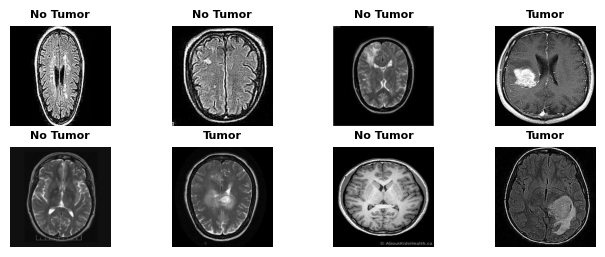

In [23]:
class_names = ['No Tumor', 'Tumor']

plt.figure(figsize=(8, 6))
for i in range(8):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i]], color='black', fontsize=8, fontweight='bold')
    plt.axis("off")
plt.show()

In [24]:
# Convert target values to one-hot vectors
y_train_encoded = to_categorical(y_train, num_classes=2)
y_test_encoded = to_categorical(y_test, num_classes=2)

sequential model building

In [27]:
# Define the CNN model
model = Sequential()

# convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(INPUT_SIZE, INPUT_SIZE, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))


model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,384,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,404,034 (5.36 MB)

 Trainable params: 1,404,034 (5.36 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train_encoded,
    epochs=15,
    validation_data=(X_test, y_test_encoded),
    callbacks=[early_stopping]
)

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 312ms/step - accuracy: 0.6453 - loss: 0.6457 - val_accuracy: 0.8533 - val_loss: 0.3806
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 303ms/step - accuracy: 0.8322 - loss: 0.4016 - val_accuracy: 0.9050 - val_loss: 0.2406
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 303ms/step - accuracy: 0.8974 - loss: 0.2587 - val_accuracy: 0.9300 - val_loss: 0.1840
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 305ms/step - accuracy: 0.9489 - loss: 0.1473 - val_accuracy: 0.9450 - val_loss: 0.1784
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 304ms/step - accuracy: 0.9582 - loss: 0.1229 - val_accuracy: 0.9733 - val_loss: 0.1003
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 305ms/step - accuracy: 0.9768 - loss: 0.0778 - val_accuracy: 0.9700 - val_loss: 0.1085
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 304ms/step - accuracy: 0.9815 - loss: 0.0478 - val_accuracy: 0.9717 - val_loss: 0.0925
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 304ms/step - accuracy: 0.9873 - loss: 0.0346 - val_accu

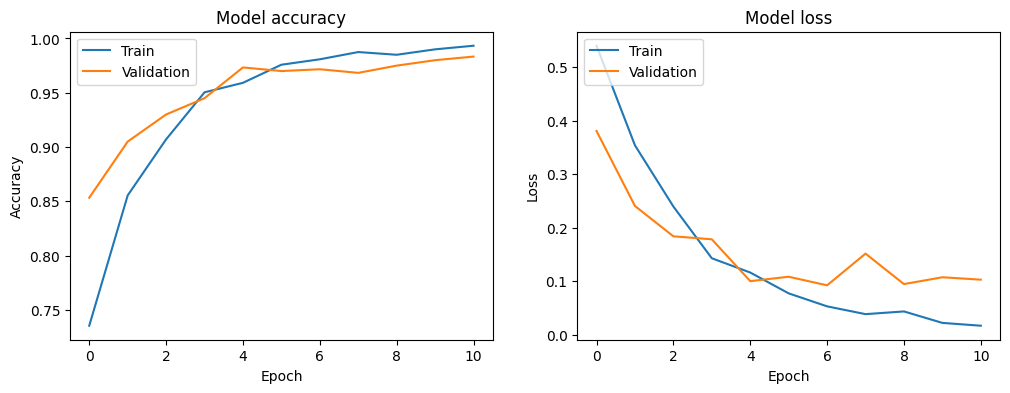

In [29]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


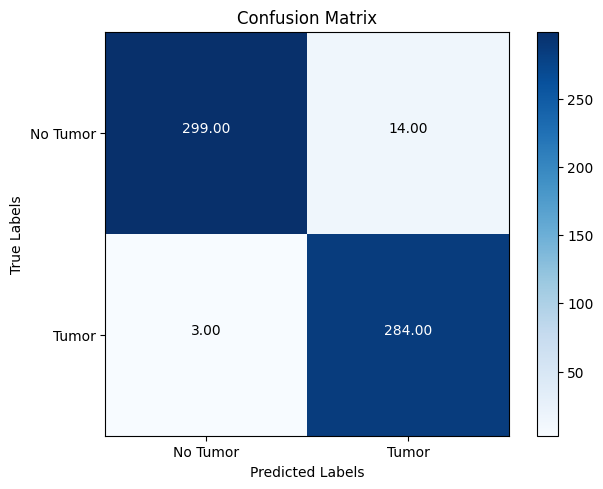

In [32]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')

In [34]:
# Display classification report
report = classification_report(y_test, y_pred_classes, target_names=class_names)
print(report)

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print('Accuracy:', accuracy_score(y_test, y_pred_classes))

              precision    recall  f1-score   support

    No Tumor       0.99      0.96      0.97       313
       Tumor       0.95      0.99      0.97       287

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Accuracy: 0.9716666666666667


In [36]:
# Freeze the layers of the CNN model
for layer in model.layers:
    layer.trainable = False

# feature extraction model
feature_extractor = Model(model.inputs, model.layers[-4].output)
feature_extractor.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 21632)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,392 (75.75 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19,392 (75.75 KB)

In [37]:
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


SVM Classifier Accuracy: 0.98
              precision    recall  f1-score   support

    No Tumor       0.98      0.98      0.98       313
       Tumor       0.98      0.98      0.98       287

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



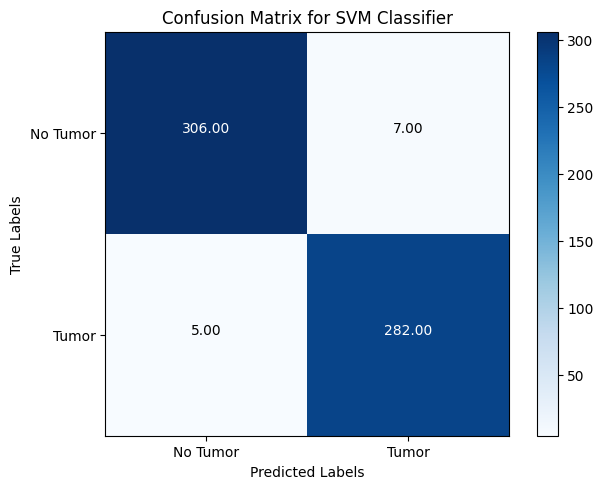

In [45]:
svm_classifier = SVC(kernel='linear')

svm_classifier.fit(X_train_features, y_train)

y_pred_svm = svm_classifier.predict(X_test_features)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print('SVM Classifier Accuracy:', accuracy_svm)
print(classification_report(y_test, y_pred_svm, target_names=class_names))

# confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plot_confusion_matrix(cm_svm, classes=class_names, title='Confusion Matrix for SVM Classifier')

Random Forest Classifier Accuracy: 0.96
              precision    recall  f1-score   support

    No Tumor       0.98      0.95      0.96       313
       Tumor       0.94      0.98      0.96       287

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



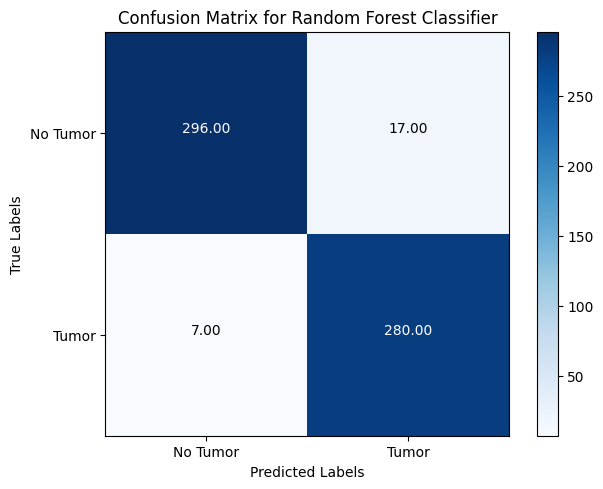

In [42]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_features, y_train)

y_pred_rf = rf_classifier.predict(X_test_features)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print('Random Forest Classifier Accuracy:', accuracy_rf)

# classification report
print(classification_report(y_test, y_pred_rf, target_names=class_names))

# confusion matrix 
cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm_rf, classes=class_names, title='Confusion Matrix for Random Forest Classifier')

Logistic Regression Classifier Accuracy: 0.98
              precision    recall  f1-score   support

    No Tumor       0.99      0.97      0.98       313
       Tumor       0.97      0.99      0.98       287

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



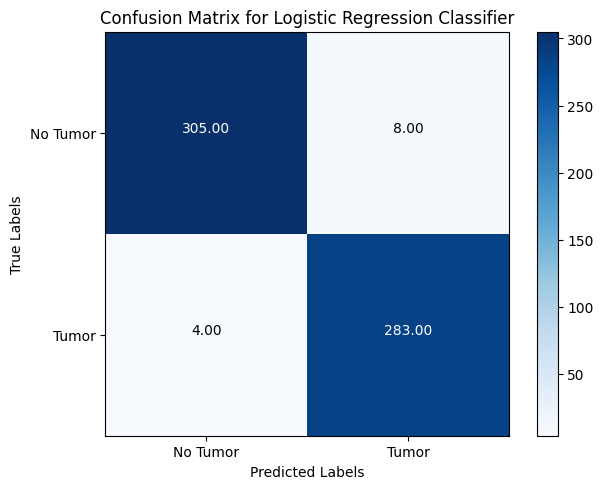

In [46]:
logistic_regression_classifier = LogisticRegression(max_iter=1000)
logistic_regression_classifier.fit(X_train_features, y_train)

y_pred_lr = logistic_regression_classifier.predict(X_test_features)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
print('Logistic Regression Classifier Accuracy:', accuracy_lr)

print(classification_report(y_test, y_pred_lr, target_names=class_names))

cm_lr = confusion_matrix(y_test, y_pred_lr)

plot_confusion_matrix(cm_lr, classes=class_names, title='Confusion Matrix for Logistic Regression Classifier')


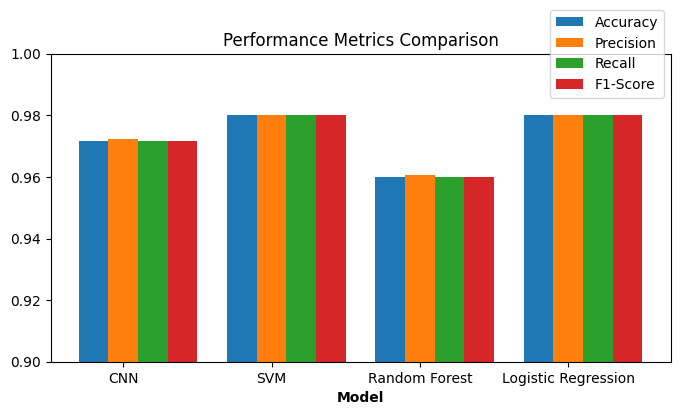

In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the performance of the CNN model
cnn_accuracy = accuracy_score(y_test, y_pred_classes)
cnn_precision = precision_score(y_test, y_pred_classes, average='weighted')
cnn_recall = recall_score(y_test, y_pred_classes, average='weighted')
cnn_f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Evaluate the performance of the SVM model
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm, average='weighted')
svm_recall = recall_score(y_test, y_pred_svm, average='weighted')
svm_f1 = f1_score(y_test, y_pred_svm, average='weighted')

# Evaluate the performance of the Random Forest model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf, average='weighted')
rf_recall = recall_score(y_test, y_pred_rf, average='weighted')
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')

# Evaluate the performance of the Logistic Regression model
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr, average='weighted')
lr_recall = recall_score(y_test, y_pred_lr, average='weighted')
lr_f1 = f1_score(y_test, y_pred_lr, average='weighted')

# Prepare data for plotting
models = ['CNN', 'SVM', 'Random Forest', 'Logistic Regression']
accuracies = [cnn_accuracy, svm_accuracy, rf_accuracy, lr_accuracy]
precisions = [cnn_precision, svm_precision, rf_precision, lr_precision]
recalls = [cnn_recall, svm_recall, rf_recall, lr_recall]
f1_scores = [cnn_f1, svm_f1, rf_f1, lr_f1]

barWidth = 0.2
r1 = np.arange(len(accuracies))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.figure(figsize=(8, 4))

plt.bar(r1, accuracies, width=barWidth, label='Accuracy')
plt.bar(r2, precisions, width=barWidth, label='Precision')
plt.bar(r3, recalls, width=barWidth, label='Recall')
plt.bar(r4, f1_scores, width=barWidth, label='F1-Score')

plt.xlabel('Model', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(accuracies))], models)
plt.ylim(0.9, 1)
plt.title('Performance Metrics Comparison')
plt.legend(loc='center right', bbox_to_anchor=(1, 1))
plt.show()